# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

import tiktoken

## Downloading Dataset

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Tonenizer de OpenAI

In [3]:
encoding = tiktoken.get_encoding("cl100k_base")  # GPT-4

def encode(text: str) -> List[int]:
    return encoding.encode(text)

def decode(ids: List[int]) -> str:
    return encoding.decode(ids)

vocab_size = encoding.n_vocab
print(f"Vocab size: {vocab_size}")

Vocab size: 100277


In [4]:
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Dataloaders

In [5]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [6]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 100277, 'bias': True, 'ff_class': None, 'moe': None}


In [7]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [10]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [11]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [12]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [13]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Training

In [15]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/3087 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W1114 23:13:44.507000 6378 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_induc

Epoch 1 training loss: 4.0515


  0%|          | 0/339 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 6.79226: 100%|██████████| 339/339 [00:04<00:00, 81.98it/s]


Epoch 1 validation loss: 5.5456


loss 4.12941: 100%|██████████| 3087/3087 [01:29<00:00, 34.35it/s]


Epoch 2 training loss: 4.1872


val_loss 6.81975: 100%|██████████| 339/339 [00:03<00:00, 91.87it/s] 

Epoch 2 validation loss: 5.5695
Training complete.


### Quick test

In [16]:
generate("To be", max_new_tokens=100,use_cache=True)

"To be\nWe shall wasitud hast their seeking he in a quarry, let you\nFor end of the people.\n\nCORIOLANUS:\nHon be you tooI' absence inquire,\nAnd be off.\n\nCOMINIUS:\nMer better eject me. If death out ',\nmninelove not not, IreatUS:\nSay not flatter all the canon, Caius, bul,\nWhich are their hearts worth in this do dida men.\nNay.\nWhat: me.\n\nBRUT"

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [17]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    model: nn.Module,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: Optional[int] = None,  # None = no aplicar
    top_p: Optional[float] = None,  # None = no aplicar
) -> Optional[str]:

    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Determinar entrada condicional
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        # Forward del modelo
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits, kv_cache = out, None

        logits = logits[:, -1, :]

        # --- Greedy decoding (temperatura = 0 o muy baja) ---
        if temperature < 1e-8:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        else:
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

            # --- Top-k sampling ---
            if top_k is not None and top_k > 0:
                top_k_probs, top_k_indices = torch.topk(probs, min(top_k, probs.size(-1)))
                probs = torch.zeros_like(probs)
                probs.scatter_(1, top_k_indices, top_k_probs)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # --- Top-p sampling ---
            if top_p is not None and top_p < 1.0:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumsum_probs = torch.cumsum(sorted_probs, dim=-1)

                # Remover tokens donde la prob acumulada excede top_p
                sorted_indices_to_remove = cumsum_probs > top_p
                # Mantener al menos el primer token
                sorted_indices_to_remove[..., 0] = False

                # Crear máscara en el orden original
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                probs[indices_to_remove] = 0.0
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # Muestrear
            next_token = torch.multinomial(probs, num_samples=1)

        # concatenar al prompt
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Compare generate vs generateV2

Add your comments and findings

In [18]:
print(generate("To be", max_new_tokens=100,use_cache=True))

To be wild sir on
Des them often I never serve bring forced inment,
Prithee now, nor comes
To curse mercyates of officers what with wager have struck his name as he's breath upon him. To a market_COUNT die,
But came
They are to them, we it.

MARCIUS:
'Tis sewing me inv Therefore at them, setreport I have cutent.

CORIOLANUS:
IOLANUS:
I sir of him to the people and


In [19]:
print("=== GREEDY ===")
print(generateV2("To be", model, max_new_tokens=100, use_cache=True, temperature=0))

=== GREEDY ===
To be consul, and
The gods, and be consul, and
The gods, and the people, and
The gods, and the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and the people, and
To


In [20]:
print("=== TEMP 0.7 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=0.7))

=== TEMP 0.7 ===
To be consul
To the business.

COMINIUS:
Consider, take it shall be ourove a point double to the people,
Which, how a body
I' theiles of the godsBRUTUS:
The gods, as I have made,
As, can you be, and of Rome
him, sir.

COMINIUS:
There, you not,
I pray do disdain to him to the Capitol, was the other.
Now, they say here.

BRUTUS:
The people,



In [21]:
print("=== TOP-K=10 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_k=10))

=== TOP-K=10 ===
To be gone,
That's Rome have shed.

MARCIUS:
I would?

BRUTUS:
No, if the Capitol,
That is, I do the world.

CORIOLANUS:
He has he did to be ab of this, the other them; and
The people'stis of
Of I cannot with my lord. I'll the matter.

SICINIUS:
He did to do it, sir; which.

VIRGILIA:
We must not's to


In [22]:
print("=== TOP-K=40 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_k=40))

=== TOP-K=40 ===
To be sworn at
Hisartius you.

BRUTUS:
To express,
And 'tw liberties
Thou ladyay, the people, and, he will be with them all to such
Have, they had I will
Than; and the city, and he goes.

MENENIUS:
'Tis a trad, you,
To'er: but is 'SICINIUS:
On, you shall do.
Now, what he
That's they have been,
But is '


In [23]:
print("=== TOP-P=0.9 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_p=0.9))

=== TOP-P=0.9 ===
To be, thou minute him,
In will the world.

SICINIUS:
Y you have do way to theMust myselfes home,
And accused he hath not.
Here,
That would have their voices, and come, in this labour with forth
Than;
And venture me'd and provideiolanus the Tar remain 'em; which your lady,
But,
When and conveying sweet would wounded.

MENENENIUS:
O, the spirit now.

MENIUS:
For you



In [24]:
print("=== TEMP 0.7 + TOP-P 0.9 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=0.7, top_p=0.9))

=== TEMP 0.7 + TOP-P 0.9 ===
To be consul
That's could only put our ownour
In would noble give the market-place.

BRUTUS:
Let he did, I will not shall tell us.

MENENENIUS:
We do at first, as if I cannot he be or being 'tis, and give
Of they speak.

MENIUS:
Let's as his Citizen:
He did he did to them on you,
That you.

CORIOLANUS:
You have me,--

S


In [25]:
print("=== TEMP 1.5 + TOP-K=50 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.5, top_k=50))

=== TEMP 1.5 + TOP-K=50 ===
To be
Than dangerous among, which their bed his
Hath me, who,
and.

AUFIDI Citizen:
I let all the man not upon's true should? of all joy, who. Come.

First Senator:
MarThere!

VIRGIL,
What was me, come, that a pace you. For do't; O
In have him that he is 'tis on!
How but you the general, no more, he hadst, that I'll keep in



In [26]:
print("=== TEMP 0.5 + TOP-P 0.8 ===")
print(generateV2("To be", model, max_new_tokens=50, temperature=0.5, top_p=0.8))

=== TEMP 0.5 + TOP-P 0.8 ===
To be
Than that have been, and one that
That must be swornENENIUS:
I'll be consul, you have been too.

CORIOLANUS:
IOLANUS:
IOLANUS:
I'll are the people


## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [27]:
class ExpertSwiGLU(nn.Module):
    """Expert con arquitectura SwiGLU"""
    def __init__(self, config: GPTConfig) -> None:
        super().__init__()
        hidden_dim = 4 * config.n_embd

        self.w1 = nn.Linear(config.n_embd, hidden_dim, bias=False)
        self.w2 = nn.Linear(config.n_embd, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, config.n_embd, bias=False)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x) -> torch.Tensor:
        # SwiGLU: silu(w1(x)) ⊙ w2(x)
        return self.dropout(self.w3(F.silu(self.w1(x)) * self.w2(x)))


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [28]:
class ExpertGeGLU(nn.Module):
    """Expert con arquitectura GeGLU"""
    def __init__(self, config: GPTConfig) -> None:
        super().__init__()
        hidden_dim = 4 * config.n_embd

        self.w1 = nn.Linear(config.n_embd, hidden_dim, bias=False)
        self.w2 = nn.Linear(config.n_embd, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, config.n_embd, bias=False)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x) -> torch.Tensor:
        # GeGLU: gelu(w1(x)) ⊙ w2(x)
        return self.dropout(self.w3(F.gelu(self.w1(x)) * self.w2(x)))

In [29]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, C)
        """
        B, T, C = x.size()
        num_experts = len(self.experts)
        k = self.args.num_experts_per_token

        # ---- 1. Compute gating logits and probabilities ----
        gate_logits = self.gate(x)                      # (B, T, E)
        gate_probs = F.softmax(gate_logits, dim=-1)     # (B, T, E)

        # ---- 2. Select top-k experts per token ----
        topk_weights, topk_idx = torch.topk(gate_probs, k, dim=-1)   # (B, T, k)

        # Normalizar los pesos top-k para que sumen 1
        topk_weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True)  # (B, T, k)

        # ---- 3. Flatten para procesamiento por lotes ----
        x_flat = x.view(-1, C)  # (B*T, C)

        # Preparar salida
        output = torch.zeros_like(x_flat)  # (B*T, C)

        # ---- 4. Procesar cada expert ----
        for i in range(num_experts):
            # Encontrar qué tokens van al expert i
            # topk_idx: (B, T, k) -> queremos saber si i está en alguno de los k
            expert_mask = (topk_idx == i).any(dim=-1)  # (B, T)
            expert_mask_flat = expert_mask.view(-1)    # (B*T,)

            if expert_mask_flat.sum() == 0:
                continue  # No hay tokens para este expert

            # Obtener tokens que van al expert i
            expert_input = x_flat[expert_mask_flat]  # (N, C) donde N = num tokens
            expert_output = self.experts[i](expert_input)  # (N, C)

            # Obtener los pesos correspondientes
            # Para cada token en expert_input, necesitamos su peso
            # topk_idx (B, T, k) -> ver en qué posición de k está el expert i
            flat_topk_idx = topk_idx.view(B*T, k)  # (B*T, k)
            flat_topk_weights = topk_weights.view(B*T, k)  # (B*T, k)

            # Para los tokens seleccionados, obtener sus pesos
            selected_topk_idx = flat_topk_idx[expert_mask_flat]  # (N, k)
            selected_topk_weights = flat_topk_weights[expert_mask_flat]  # (N, k)

            # Encontrar en qué posición está el expert i para cada token
            expert_weights = torch.zeros(selected_topk_idx.size(0), device=x.device)
            for j in range(k):
                mask_j = (selected_topk_idx[:, j] == i)
                expert_weights[mask_j] = selected_topk_weights[mask_j, j]

            # Aplicar pesos y acumular
            weighted_output = expert_output * expert_weights.unsqueeze(-1)
            output[expert_mask_flat] += weighted_output

        # ---- 5. Reshape de vuelta ----
        output = output.view(B, T, C)
        return output

In [30]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()

        # Crear experts con diferentes arquitecturas
        experts = []
        for i in range(config.moe.num_experts):
            if i % 2 == 0:
                # Experts pares: SwiGLU
                experts.append(ExpertSwiGLU(config))
            else:
                # Experts impares: GeGLU
                experts.append(ExpertGeGLU(config))

        self.moe = MoELayer(
            experts=experts,
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [31]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=2)

# Training TinyGPT-MoE


In [32]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [33]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [34]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/3087 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
loss 4.00693: 100%|██████████| 3087/3087 [03:10<00:00, 16.21it/s]


Epoch 1 training loss: 3.9743


  0%|          | 0/339 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 6.78809: 100%|██████████| 339/339 [00:07<00:00, 47.26it/s]


Epoch 1 validation loss: 5.5081


  0%|          | 0/3087 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss 3.85958: 100%|██████████| 3087/3087 [03:09<00:00, 16.26it/s]


Epoch 2 training loss: 3.8455


val_loss 6.84794: 100%|██████████| 339/339 [00:07<00:00, 47.72it/s]

Epoch 2 validation loss: 5.5322
Training complete.


In [35]:
print("=== GREEDY ===")
print(generateV2("To be", model_moe, max_new_tokens=100, use_cache=True, temperature=0))

=== GREEDY ===
To be
To the people, and
To the people,
And the people, and the people,
And the people,
And keep your voices, and the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and
To the people, and



In [36]:
print("=== TEMP 0.7 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=0.7))

=== TEMP 0.7 ===
To be the belly?

AUFIDIUS:
I have wounds and not,
And I may shall be angry he hated, that shall
By the gods assist the field, to you have done in the rest, to the gods.

CORIOLANUS:
Hence:
Shall do each;
I may be content to fam plot,
As they have the gods!
Marcius.

CORIOLANUS:
You are they were in't:
The faces is a have done.

SICINI


In [37]:
print("=== TOP-K=10 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_k=10))

=== TOP-K=10 ===
To be so,
And he did you have the senate.

MENENIUS:
O, and
To answer: the city and
That they have been'd to be so are at the state:
O, sir.

MENENENIUS:
No, if he did it, I do it is the Capitol.

LARTIUS:
IUS:
IUS:
No, I'll hear your voices, you,
You have the people have a mile:
Let him, my lord.




In [38]:
print("=== TOP-K=40 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_k=40))

=== TOP-K=40 ===
To be
That have made I know the people are the business,
But the rest have done!
I prithee, that, and now; I pray, I shall
Be taken of us! whyither 'tis not be calm.

SICINIUS:
I have seen him, though and
Than what you can do you not we to the senate was an hour a nature,
That the city,
The gods!
I were he might
The noble to
Which we have my
Your


In [39]:
print("=== TOP-P=0.9 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_p=0.9))

=== TOP-P=0.9 ===
To be now, where you;
Than come, layius?

MENIUS:
O, whatIA:
MENENIUS:
No more!
My horse is, these speak.

BRUTUS:
ItVOLUMNIA:
We stand a awhile, and the corn, I will I will thus, we are as:
Too on,
But by the men, to be misery;
Would' the tongues
d go on ingons so with it
MyubVOLUMNIA:
Let have


In [40]:
print("=== TEMP 0.7 + TOP-P 0.9 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=0.7, top_p=0.9))

=== TEMP 0.7 + TOP-P 0.9 ===
To be you are all.

BRUTUS:
On their trenchesSe rather must I have fought
That he was an hour,
And she's spirit, and our voices, you are me all the people, who,
That we do you
He will make a disease that you not do, I do it is
That as her friends to the people, to't.

CORIOLANUS:
IOLANUS:
Theed, to Rome.

CORIOLANUS:
How to lose it


In [41]:
print("=== TEMP 1.5 + TOP-K=50 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.5, top_k=50))

=== TEMP 1.5 + TOP-K=50 ===
To be
Of all with us Cori
Against the city: you, and clubs the business,
Let the consul.

MARCIUS:
Come, by that do ye were and we do by the way,
Who:
Why at no power now the people should but not,
Here's some.

For their suff in my husband now she enough out,
How you can show?

Messenger:
Marcius;
I would have more power to the senate more!

Second Citizen:
O me by the matter: he


In [42]:
print("=== TEMP 0.5 + TOP-P 0.8 ===")
print(generateV2("To be", model_moe, max_new_tokens=50, temperature=0.5, top_p=0.8))

=== TEMP 0.5 + TOP-P 0.8 ===
To be
The common' the senate of your voices, and
To the people,
I' the body of the people.

BRUTUS:
The common
That's one that's one that
As you have my lord.

MENENENEN


## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [43]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


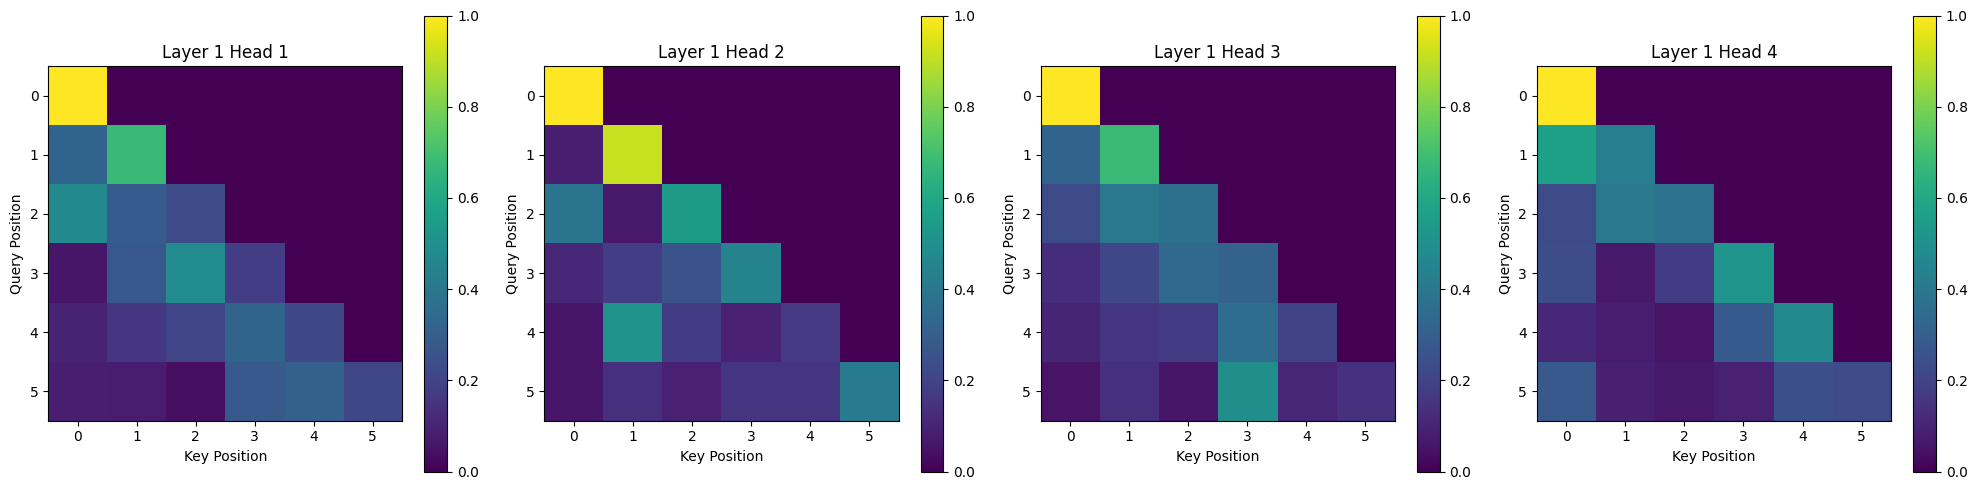

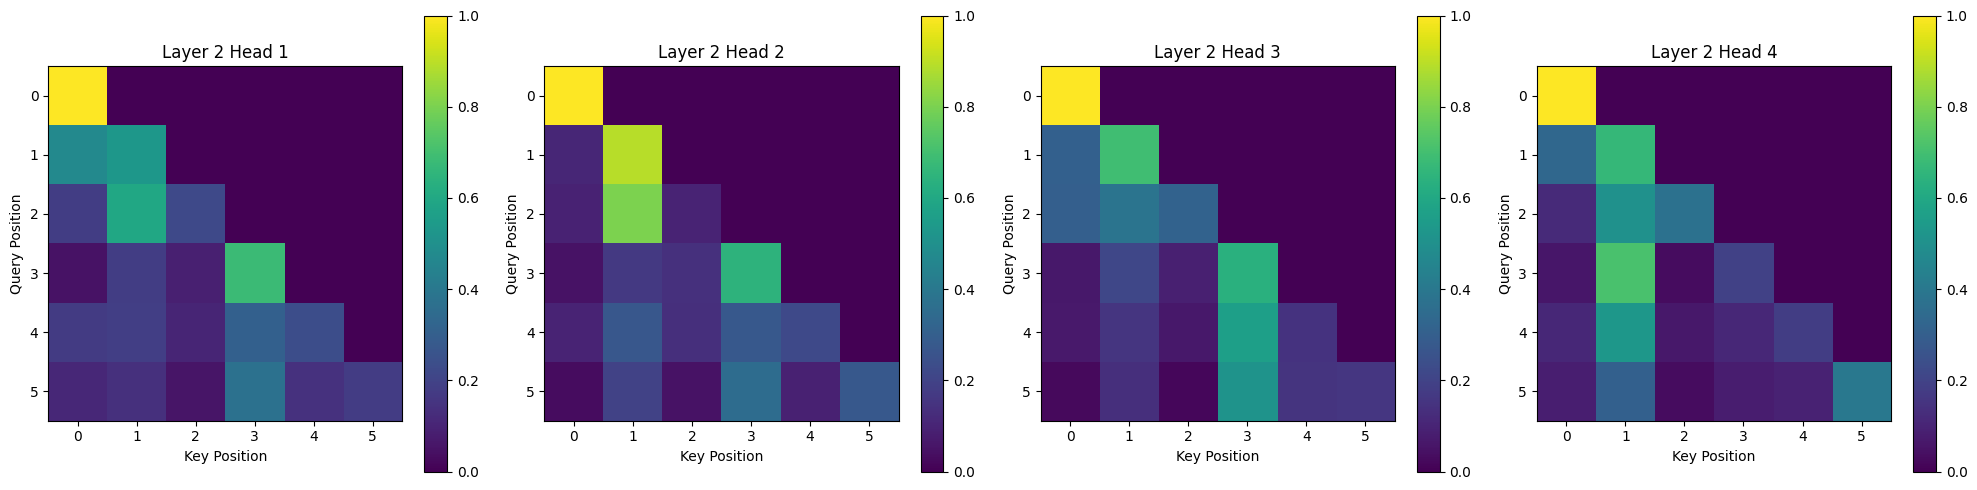

In [44]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

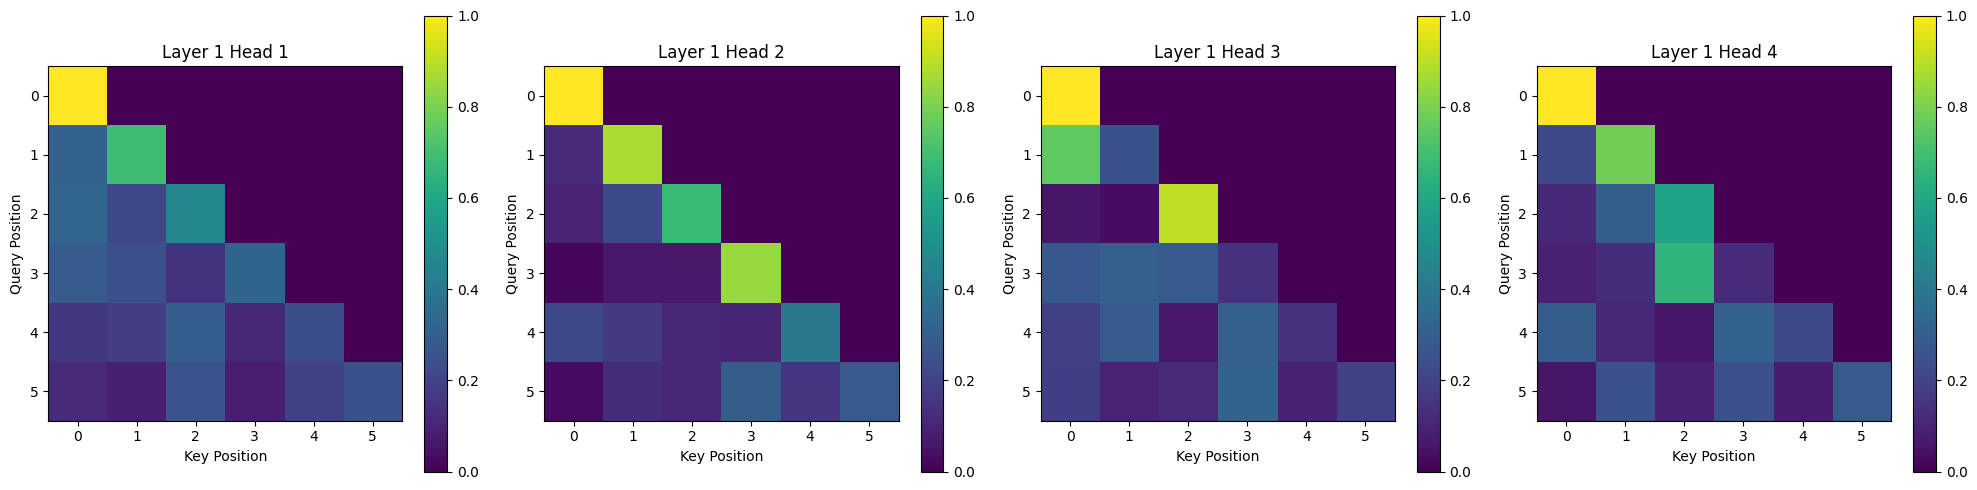

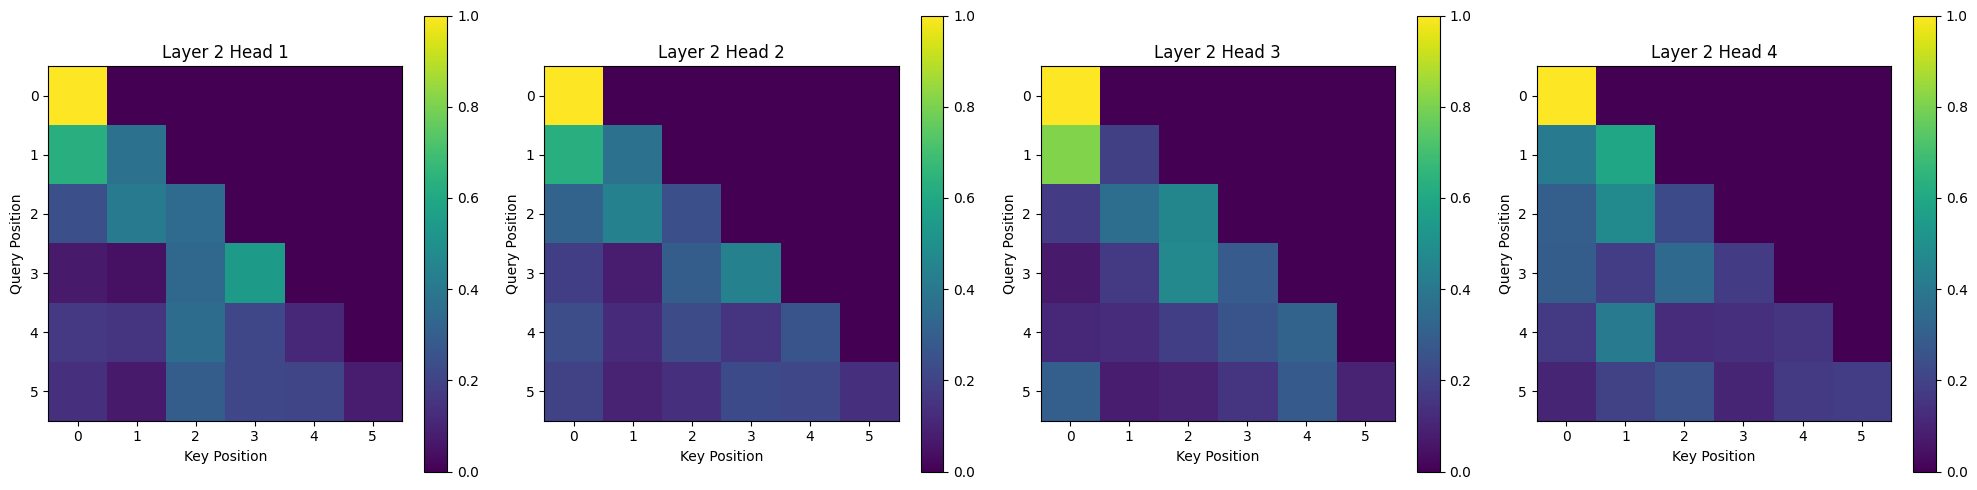

In [45]:
visualize_attention(model_moe, prompt)

# Conclusions

En esta última variante de TinyGPT se mantiene la estructura general del modelo, incluidas las capas MoE y la cantidad de expertos, pero se modifica de manera puntual y significativa la arquitectura interna de cada experto. Este cambio hace que el MoE ya no funcione como un conjunto de expertos idénticos, sino como un módulo heterogéneo donde cada experto tiene una capacidad distinta para transformar representaciones.

Esto genera varios efectos observables:

1. Mayor diversidad funcional entre expertos  
Al no compartir ya la misma arquitectura, es más probable que cada experto aprenda transformaciones diferentes. Aunque no existe garantía de especialización fuerte en un modelo pequeño, sí aparece una mayor diversificación en las activaciones internas, lo que hace al MoE menos redundante que en versiones anteriores.

2. Mejor aprovechamiento del gating  
El gating sigue siendo el mismo, pero ahora tiene algo real que elegir. Antes todos los expertos producían funciones muy parecidas entre sí. Ahora al ser arquitecturalmente distintos, el gating puede asignar tokens según qué experto resulte más útil para cada caso. Ese cambio hace que la mezcla experta ya no sea puramente simétrica y uniforme, sino más dinámica.

3. Ligeras mejoras en estabilidad y calidad de la representación  
Sin modificar la cantidad de parámetros de manera explosiva, la mayor capacidad interna de los expertos permite:
    - Reducir un poco la redundancia del MoE
    - Generar salidas con más variabilidad
    - Suavizar ciertos patrones repetitivos
    - Otorgar un pequeño margen de mejora en la pérdida durante el entrenamiento.

4. Comportamiento de generación más flexible  
Las funciones de sampling (greedy, temperature, top-k, top-p) muestran resultados algo más ricos, especialmente con top-k y top-p. No porque el modelo sea mucho más grande, sino porque el MoE aporta rutas de cómputo no uniformes, lo que aumenta la diversidad interna del modelo.

5. Un MoE conceptualmente más realista  
Aunque sigue siendo TinyGPT, esta versión es la que más se aproxima a un MoE como se usa en modelos modernos: expertos heterogéneos + gating compartido. La mezcla resulta más expresiva y menos redundante, lo que era una limitación clara en las versiones anteriores.

# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

